In [1]:
from xgb_results import xgb_results_regression
from pprint import pprint
from utils import *
from get_data import get_uci_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from genetic import GeneticAlgorithmSampler
from fitness_funcs import *
from IPython.display import clear_output
from plots import *

In [2]:
x_train, x_test, y_train, y_test, description = get_uci_dataset(2) #Dataset 1 has 2 colums we need to predict...
pprint(description)

Number of features:  23
Number of training examples:  1711
Number of test examples:  428
{'categorical features': [],
 'dataset name': 'AIDS Clinical Trials Group Study 175',
 'number of features': 23,
 'number of samples': 2139,
 'variables information':        name     role        type         demographic  \
0    pidnum       ID     Integer                None   
1       cid   Target      Binary                None   
2      time  Feature     Integer                None   
3       trt  Feature     Integer                None   
4       age  Feature     Integer                 Age   
5      wtkg  Feature  Continuous                None   
6      hemo  Feature      Binary                None   
7      homo  Feature      Binary  Sexual Orientation   
8     drugs  Feature      Binary                None   
9    karnof  Feature     Integer                None   
10   oprior  Feature      Binary                None   
11      z30  Feature      Binary                None   
12   zprior  Fea

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1711, 23)
(1711,)
(428, 23)
(428,)


In [4]:
all_data_results = xgb_results_regression(x_train, x_test, y_train, y_test)
pprint(all_data_results)

{'Testing Metrics': {'MSE': 0.09032473560251866,
                     'Pearson': 0.7116221023900426,
                     'R^2 Score': 0.49901455274133955,
                     'Spearman': 0.607362871658546},
 'Training Metrics': {'MSE': 0.0004781508511815307,
                      'Pearson': 0.9988596827205314,
                      'R^2 Score': 0.9974183972225262,
                      'Spearman': 0.7454155672704781}}


In [5]:
guesses = get_baseline_guesses(np.concatenate((y_train, y_test)))
baseline_results = get_baseline_results(y_test, guesses)
pprint(baseline_results)

{'mean': {'MSE': 0.18035174548510868, 'R^2': -0.00031956111497111195},
 'median': {'MSE': 0.23598130841121495, 'R^2': -0.308868501529052}}


In [6]:
# sample rates are from 10 to 1000 in increments of 10
COMPARE = True
REDUNDANCY = 1 # TODO: was 5
sample_sizes = [10, 50] # was [10, 50, 100, 150]

mse_dict_random, mse_dict_ga = {}, {}


for index, sample_size in enumerate(sample_sizes):
    #clear_output()
    print('Sample Size:', sample_size, '\n')
    
    mse_list_random, mse_list_ga = [], []
    
    for i in range(REDUNDANCY):
        if (REDUNDANCY > 1):
            print('Iteration {}/{}'.format(i+1, REDUNDANCY))
        np.random.seed(i)
        
        x_train_sample, y_train_sample = sample_data(x_train, y_train, sample_size)
        
        Sampler = GeneticAlgorithmSampler(
            fitness_function=fitness_wasserstein_distance,
            sample_size=sample_size,
            x_train=x_train,
            y_train=y_train,
            population_size=2, # was 20
            max_generations=1, # was 10
            mutation_rate=0.6,
            mutation_cap=2,
            elite_size=1, # was 2
            verbose=False
        )
        
        x_train_new_sample, y_train_new_sample, history = Sampler.sample()
        
        results_random = xgb_results_regression(x_train_sample, x_test, y_train_sample, y_test)
        results_ga = xgb_results_regression(x_train_new_sample, x_test, y_train_new_sample, y_test)
        
        mse_random = results_random['Testing Metrics']['MSE']
        mse_ga = results_ga['Testing Metrics']['MSE']
        mse_list_random.append(mse_random)
        mse_list_ga.append(mse_ga)
        
        if COMPARE:
            print('\tRandom:', mse_random)
            print('\tGA:', mse_ga)
        print()

    mse_dict_random[sample_size] = mse_list_random
    mse_dict_ga[sample_size] = mse_list_ga

    average_mse_random_dict = {key: np.mean(value) for key, value in mse_dict_random.items()}
    average_mse_ga_dict = {key: np.mean(value) for key, value in mse_dict_ga.items()}

    std_mse_random_dict = {key: np.std(value) for key, value in mse_dict_random.items()}
    std_mse_ga_dict = {key: np.std(value) for key, value in mse_dict_ga.items()}


Sample Size: 10 

	Generation 1
		Best fitness:  2.836301945261583
	Random: 0.2589878201426133
	GA: 0.1405529576703598

Sample Size: 50 

	Generation 1
		Best fitness:  2.553979410759326
	Random: 0.19887588034376272
	GA: 0.1268838408878699



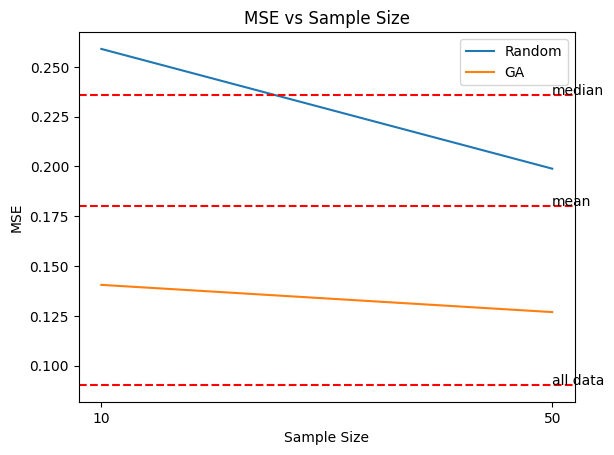

In [7]:
# graph mse results
plt.plot(list(average_mse_random_dict.keys()), list(average_mse_random_dict.values()))
plt.plot(list(average_mse_ga_dict.keys()), list(average_mse_ga_dict.values()))
plt.xlabel('Sample Size')
plt.ylabel('MSE')
plt.legend(['Random', 'GA'])
# Draw a line for each baseline
for baseline, value in baseline_results.items():
    plt.axhline(value["MSE"], color='r', linestyle='--')
    plt.text(sample_sizes[-1], value["MSE"], baseline)

# Draw a line for best result
all_data_mse = all_data_results['Testing Metrics']['MSE']
plt.axhline(all_data_mse, color='r', linestyle='--')
plt.text(sample_sizes[-1], all_data_mse, 'all data')
    
plt.xticks(sample_sizes) #TODO: change this if needed
plt.title('MSE vs Sample Size')
plt.show()

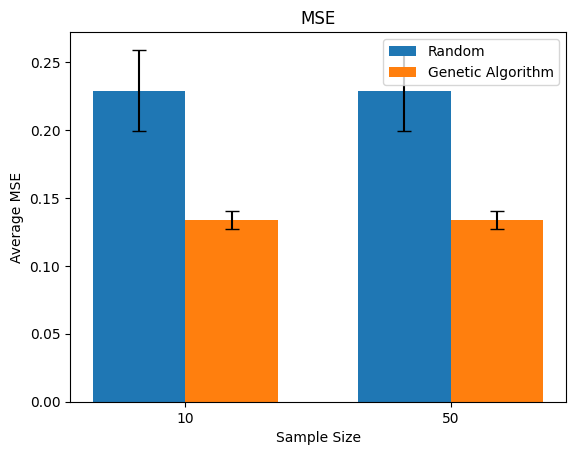

In [8]:
plot_comparison_bar(metric_name='MSE',
                    dictionaries = [mse_dict_random, mse_dict_ga],
                    labels = ['Random', 'Genetic Algorithm'])